In [1454]:
# 导入函数包

import pandas as pd
import numpy as np
from causis_api.data import *
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from matplotlib.patches import Rectangle
from tqdm import tqdm

In [1543]:
# 导入数据集

jd = pd.read_csv('R.CN.DCE.jd.0004.csv', index_col='CLOCK', parse_dates=True)
c = pd.read_csv('R.CN.DCE.c.0004.csv', index_col='CLOCK', parse_dates=True)
m = pd.read_csv('R.CN.DCE.m.0004.csv', index_col='CLOCK', parse_dates=True)

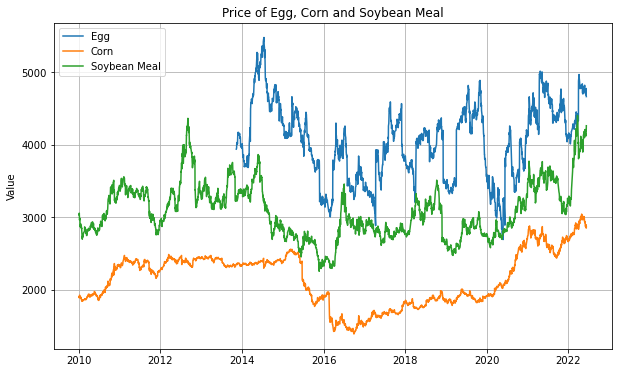

In [1544]:
# 前期数据处理与观察

plt.figure(figsize=(10,6))
plt.plot(jd['CLOSE'], label='Egg')
plt.plot(c['CLOSE'], label='Corn')
plt.plot(m['CLOSE'], label='Soybean Meal')
plt.ylabel('Value')
plt.title('Price of Egg, Corn and Soybean Meal')
plt.legend()
plt.grid()
plt.show()

In [1425]:
c = c[c.index>='2013-11-11']
m = m[m.index>='2013-11-11']

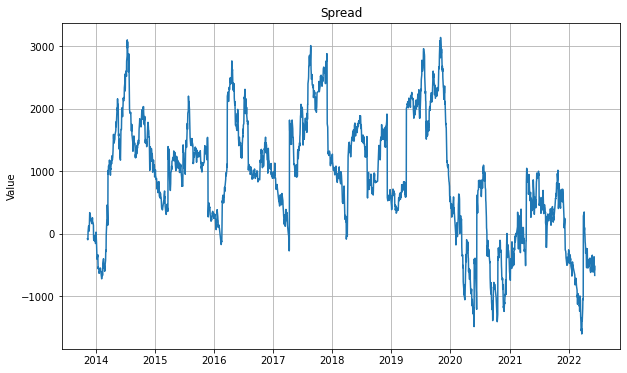

In [1545]:
asset1 = 2 * jd
asset2 = 2 * c + m
plt.figure(figsize=(10,6))
plt.plot(asset1['CLOSE']-asset2['CLOSE'])
plt.ylabel('Value')
plt.title('Spread')
plt.grid()
plt.show()

In [1546]:
# ADF测试时间序列数据是否稳定

def run_adf(timeseries):
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(timeseries, regression = "ct")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [1547]:
run_adf((asset1['CLOSE']-asset2['CLOSE']).dropna())

ADF Statistic: -3.895755
p-value: 0.012297
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128


In [1557]:
# 数据预处理
jd = jd[jd.index>='2015-02-01']
jd = jd[jd.index<='2022-02-01']
c = c[c.index>='2015-02-01']
c = c[c.index<='2022-02-01']
m = m[m.index>='2015-02-01']
m = m[m.index<='2022-02-01']
arbitrage = asset1[['CLOSE']] - asset2[['CLOSE']]
arbitrage = arbitrage[arbitrage.index>='2015-02-01']
arbitrage = arbitrage[arbitrage.index<='2022-02-01']

In [1558]:
# 计算夏普比率

def sharpe(df):
    absolute_return = sum(df['Portfolio Returns'])/Capital
    annual_return = absolute_return*365/len(df)
    volatility = (df['Portfolio Returns']/Capital).std() * np.sqrt(365)
    sharpe = annual_return / volatility
    return sharpe 

In [1559]:
# 主策略部分-买入卖出价差和止损信号识别、回报计算

list1 = []
def pair_trading(df,zscore,window,maxdown):
    df["Mean"] = df['CLOSE'].ewm(window).mean()
    df["STD"] = df['CLOSE'].ewm(window).std()
    df["Lower Bound"] = df["Mean"] - zscore * df["STD"]
    df["Upper Bound"] = df["Mean"] + zscore * df["STD"]
    
    df['Signals'] = 0.
    df['Egg'] = jd['CLOSE']
    df['Corn'] = c['CLOSE']
    df['Soybean Meal'] = m['CLOSE']
    df['Portfolio Returns'] = 0.
    df['trade'] = 0
    df['hold'] = 0
    df.index = pd.DatetimeIndex(df.index).date
    
    position = 0.
    Capital = 1000000
    last_place = "BTWN" # Last place分别为under lower bound, between bounds, above upper bounds
    jd_return = 0
    c_return = 0
    m_return = 0
    jd_lot = 0
    c_lot = 0
    m_lot = 0
    
    for i in range(1,len(df)):
        
        # 检查价差是否跨过加权移动平均值加1倍标准差界限
        if df['CLOSE'][i] > df["Upper Bound"][i] and position == 0:
            last_place = "UP"
        elif df['CLOSE'][i] < df["Lower Bound"][i] and position == 0:
            last_place = "DOWN"
        
        # 价差回归到加权移动平均线进行平仓
        if last_place == "UP BTWN" and position == -1. and df['CLOSE'][i] <= df["Mean"][i]:
            position = 0.
            df['Signals'][i]=-1
            jd_return = -jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            last_place = "DOWN BTWN"
            df['trade'][i] = 1
            df['hold'][i] = 1
            print('【平仓】买入平仓于', df.index[i])
        elif last_place == "DOWN BTWN" and position == 1. and df['CLOSE'][i] >= df["Mean"][i]:
            position = 0.
            df['Signals'][i]=1
            jd_return = jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = -c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = -m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            last_place = "UP BTWN"
            df['trade'][i] = 1
            df['hold'][i] = 1
            print('【平仓】卖出平仓于', df.index[i])
            
        # 持仓期间计算每日净值变动
        if last_place == "UP BTWN" and position == -1.:
            df['Signals'][i]=position
            jd_return = -jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['hold'][i] = 1
        elif last_place == "DOWN BTWN"  and position == 1.:
            df['Signals'][i]=position  
            df['Signals'][i]=1
            jd_return = jd_lot * (df['Egg'][i] - df['Egg'][i-1])
            c_return = -c_lot * (df['Corn'][i] - df['Corn'][i-1])
            m_return = -m_lot * (df['Soybean Meal'][i] - df['Soybean Meal'][i-1])
            df['Portfolio Returns'][i] = jd_return + c_return + m_return
            df['hold'][i] = 1
            
        # 价差两次触及加权移动平均值加1倍标准差界限时进行建仓
        if last_place == "UP" and df['CLOSE'][i] < df["Upper Bound"][i]:
            position = -1.
            df['Signals'][i]=-1.
            last_place = "UP BTWN"
            c_lot = np.ceil((2 * Capital)/(3 * df['Corn'][i]))
            m_lot = np.ceil((1 * Capital)/(3 * df['Soybean Meal'][i]))
            jd_lot = c_lot
            df['trade'][i] = 1
            print("【建仓】做空价差于", df.index[i], '买入', c_lot, '手玉米', m_lot, '手豆粕')
        elif last_place == "DOWN" and df['CLOSE'][i] > df["Lower Bound"][i]:
            position = 1.
            df['Signals'][i]=1.
            last_place = "DOWN BTWN"
            jd_lot = np.ceil(Capital/df['Egg'][i])
            c_lot = jd_lot
            m_lot = 0.5 * jd_lot
            df['trade'][i] = 1
            print("【建仓】做多价差于", df.index[i], '买入', jd_lot, '手鸡蛋')
            
        # 仓位触及止损点进行平仓
        if df['Portfolio Returns'][i] < maxdown * Capital:
            df['Portfolio Returns'][i] = maxdown * Capital
            df['Signals'][i]= 0 
            position = 0
            if last_place =='UP BTWN':
                last_place = 'UP'
            elif last_place =='DOWN BTWN':
                ast_place = 'DOWN'
            df['trade'][i] = 1
            print('【平仓】触及止损点平仓于', df.index[i])
    
    # 生成各个指标列表
    parameter = [zscore,window,maxdown,sharpe(df)]
    list1.append(parameter)
    return df

In [1560]:
pair_trading(df=arbitrage, zscore=1, window=10, maxdown=-0.01)

【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】卖出平仓于 2015-09-08
【建仓】做多价差于 2015-10-13 买入 273.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-14
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-16 买入 359.0 手玉米 138.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-04 买入 306.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做多价差于 2016-02-19 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-01 买入 416.

,CLOSE,Mean,STD,Lower Bound,Upper Bound,Signals,Egg,Corn,Soybean Meal,Portfolio Returns,trade,hold
2015-02-02,577.0,577.000000,NaN,NaN,NaN,0.0,4089.0,2468.0,2665.0,0.0,0,0
2015-02-03,665.0,623.095238,62.225397,560.869841,685.320635,0.0,4159.0,2481.0,2691.0,0.0,0,0
2015-02-04,572.0,604.416918,52.486209,551.930710,656.903127,0.0,4144.0,2498.0,2720.0,0.0,0,0
2015-02-05,646.0,616.342599,47.128813,569.213786,663.471411,0.0,4173.0,2492.0,2716.0,0.0,0,0
2015-02-06,603.0,613.142831,40.309769,572.833062,653.452601,0.0,4168.0,2504.0,2725.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,-451.0,-434.111993,231.368092,-665.480085,-202.743901,1.0,4133.0,2732.0,3253.0,22600.5,0,1
2022-01-25,-530.0,-442.829085,222.401871,-665.230956,-220.427213,1.0,4117.0,2758.0,3248.0,-9756.5,0,1
2022-01-26,-534.0,-451.117350,213.745863,-664.863213,-237.371486,1.0,4138.0,2775.0,3260.0,-494.0,0,1
2022-01-27,-502.0,-455.743045,204.349144,-660.092190,-251.393901,1.0,4186.0,2768.0,3338.0,3952.0,0,1


In [1571]:
arbitrage[1:50]

,CLOSE,Mean,STD,Lower Bound,Upper Bound,Signals,Egg,Corn,Soybean Meal,Portfolio Returns,trade,hold
2015-02-03,665.0,623.095238,62.225397,560.869841,685.320635,0.0,4159.0,2481.0,2691.0,0.0,0,0
2015-02-04,572.0,604.416918,52.486209,551.930710,656.903127,0.0,4144.0,2498.0,2720.0,0.0,0,0
2015-02-05,646.0,616.342599,47.128813,569.213786,663.471411,0.0,4173.0,2492.0,2716.0,0.0,0,0
2015-02-06,603.0,613.142831,40.309769,572.833062,653.452601,0.0,4168.0,2504.0,2725.0,0.0,0,0
2015-02-09,569.0,603.928722,40.292119,563.636603,644.220842,0.0,4166.0,2513.0,2737.0,0.0,0,0
2015-02-10,544.0,592.738096,43.871870,548.866226,636.609966,0.0,4159.0,2520.0,2734.0,0.0,0,0
2015-02-11,464.0,570.800654,65.277425,505.523229,636.078079,0.0,4118.0,2514.0,2744.0,0.0,0,0
2015-02-12,424.0,547.627432,82.354374,465.273058,629.981806,0.0,4091.0,2508.0,2742.0,0.0,0,0
2015-02-13,404.0,526.377702,92.870591,433.507111,619.248292,0.0,4113.0,2514.0,2794.0,0.0,0,0
2015-02-16,405.0,509.388890,96.525724,412.863166,605.914614,0.0,4113.0,2511.0,2799.0,0.0,0,0


In [1561]:
# 价差、均线、上下界及交易信号图

def spread_trading_plot(df):
    plt.figure(figsize = (10,6))
    plt.plot(df["Mean"])
    plt.plot(df['CLOSE'])
    plt.plot(df["Upper Bound"], color = "blue", linestyle = "dotted")
    plt.plot(df["Lower Bound"], color = "blue", linestyle = "dotted")
    plt.title("Spread of Egg, Corn and Soybean Meal")
    plt.legend(["Mean", "Spread", "Bounds"])
    plt.grid()
    plt.show()
    
    plt.figure(figsize = (10,6))
    plt.plot(df["Signals"])
    plt.title('Signals of Longing or Shorting Spread')
    plt.grid()
    plt.show()

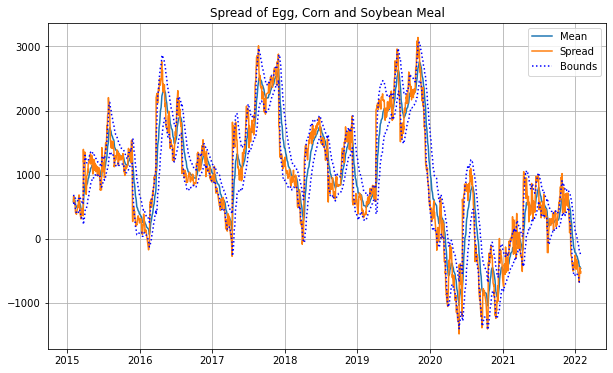

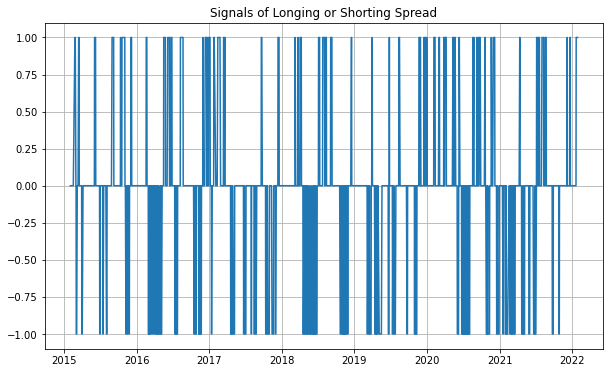

In [1562]:
spread_trading_plot(df=arbitrage)

In [1567]:
def signals_plots(df):

    buy_signals = df['Signals'] == 1.0
    sell_signals = df['Signals'] == -1.0

    # 绘制买入信号模拟图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 6000, where=buy_signals, facecolor='green', alpha=0.5)
    plt.title('Long Spread Signals Plot')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 绘制卖出信号模拟图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 6000, where=sell_signals, facecolor='red', alpha=0.5)
    plt.title('Sell Spread Signals Plot')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 绘制简单模拟仓位图
    fig = plt.figure(figsize = (10,6))
    plt.plot(jd['CLOSE'], label='Egg', color='blue', linewidth=1)
    plt.plot(c['CLOSE'], label='Corn', color='orange', linewidth=1)
    plt.plot(m['CLOSE'], label='Soybean Meal',  color='purple', linewidth=1)
    plt.fill_between(arbitrage.index, 3000, 6000, where=buy_signals, facecolor='green', alpha=0.5)
    plt.fill_between(arbitrage.index, 0, 3000, where=sell_signals, facecolor='red', alpha=0.5)
    plt.title('Simulated Position Plot')
    plt.legend()
    plt.grid()
    plt.show()

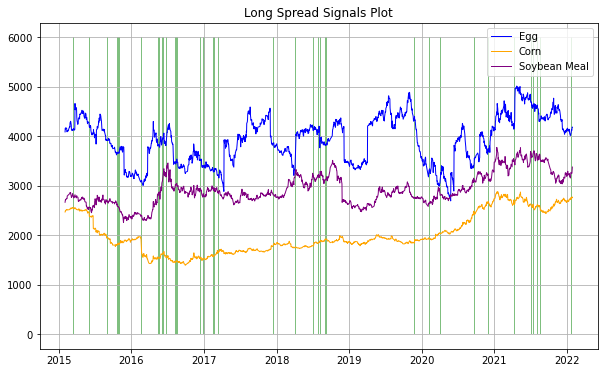

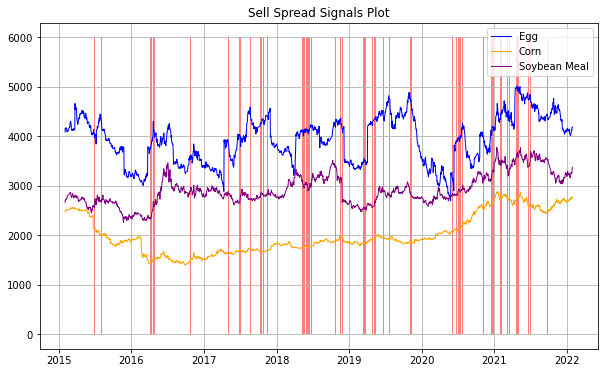

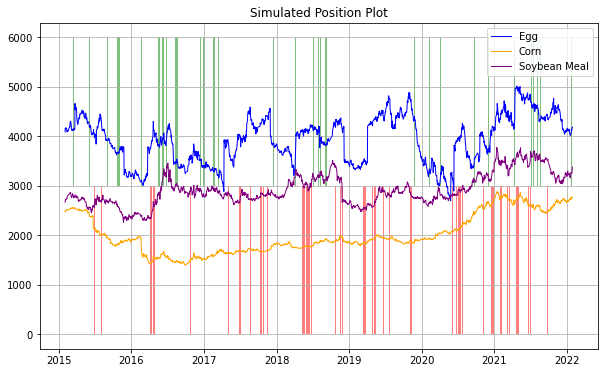

In [1568]:
signals_plots(arbitrage)

In [1565]:
# 策略表现：PNL曲线、策略回测指标

def ratio_table(df):
    # PNL曲线
    plt.figure(figsize=(10,6))
    plt.plot((df['Portfolio Returns']).cumsum())
    plt.title('Profit and Loss Plot')
    plt.ylabel('Profit and Loss')
    plt.grid()
    plt.show()
    
    # 绝对收益率
    absolute_return = sum(df['Portfolio Returns'])/Capital
    # 年化收益率
    annual_return = absolute_return*365/len(df)
    volatility = (df['Portfolio Returns']/Capital).std() * np.sqrt(365)
    # 年化波动率
    sharpe = annual_return / volatility
    # 最大回撤率
    cumulative_returns = (df['Portfolio Returns']/Capital).cumsum()
    peak = cumulative_returns.expanding().max()
    peak = peak[peak != 0]
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.dropna().min()
    # 最大回撤时间
    maxdrawdown_time = drawdown[drawdown == max_drawdown].index[0].strftime('%Y-%m-%d')
    # Calmer
    calmar = annual_return/np.abs(max_drawdown)
    # 胜率
    profitable_trades = 0
    total_trades = 0
    for trade in df[df['Portfolio Returns']!=0]['Portfolio Returns']:
        total_trades += 1
        if trade > 0:
            profitable_trades += 1
    win_rate = profitable_trades / total_trades
    # 盈亏比
    profit_sum = 0
    loss_sum = 0
    num_profit_trades = 0
    num_loss_trades = 0
    for trade in df[df['Portfolio Returns']!=0]['Portfolio Returns']:
        if trade > 0:
            profit_sum += trade
            num_profit_trades += 1
        else:
            loss_sum += trade
            num_loss_trades += 1    
    profit_loss_ratio = (profit_sum/num_profit_trades) / ((-1 * loss_sum)/num_loss_trades)
    # 平均持有期
    avg_holding_period = sum(df['hold'])/sum(df['trade'])
    
    data = [absolute_return,annual_return,volatility,sharpe,max_drawdown,calmar,win_rate,profit_loss_ratio,avg_holding_period,maxdrawdown_time]
    index = ['absolute_return','annual_return','volatility','sharpe','max_drawdown','calmar','win_rate','profit_loss_ratio','avg_holding_period','maxdrawdown_time']
    column = ['Ratios']
    ratio_table = pd.DataFrame(data=data,index=index,columns =column)
    return ratio_table

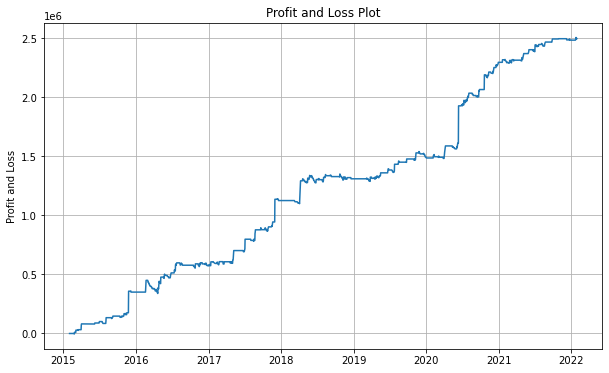

,Ratios
absolute_return,2.495811
annual_return,0.534607
volatility,0.265184
sharpe,2.015986
max_drawdown,-0.246379
calmar,2.16986
win_rate,0.496659
profit_loss_ratio,2.561301
avg_holding_period,1.319648
maxdrawdown_time,2016-04-20


In [1566]:
ratio_table(df=arbitrage)

In [1456]:
# 参数敏感性分析

input1 = [[0.5,5],[0.5,10],[0.5,15],[0.5,20],[0.5,25],[0.5,30],
          [1,5],[1,10],[1,15],[1,20],[1,25],[1,30],
          [1.5,5],[1.5,10],[1.5,15],[1.5,20],[1.5,25],[1.5,30],
          [2,5],[2,10],[2,15],[2,20],[2,25],[2,30]]
for element in tqdm(input1):
    pair_trading(df=arbitrage, zscore=element[0], window=element[1], maxdown=-0.01)

  0%|                                                    | 0/24 [00:00<?, ?it/s]

【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-26
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-17
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-02
【建仓】做多价差于 2015-04-09 买入 235.0 手鸡蛋
【平仓】卖出平仓于 2015-04-10
【建仓】做空价差于 2015-04-16 买入 269.0 手玉米 124.0 手豆粕
【平仓】触及止损点平仓于 2015-04-17
【建仓】做空价差于 2015-04-27 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-04-28
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-05-08
【建仓】做多价差于 2015-05-14 买入 226.0 手鸡蛋
【平仓】卖出平仓于 2015-05-15
【建仓】做多价差于 2015-05-21 买入 230.0 手鸡蛋
【平仓】卖出平仓于 2015-05-22
【建仓】做多价差于 2015-05-27 买入 234.0 手鸡蛋
【平仓】卖出平仓于 2015-06-01
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-

  4%|█▊                                          | 1/24 [00:18<07:00, 18.30s/it]

【平仓】卖出平仓于 2022-01-07
【建仓】做空价差于 2022-01-25 买入 242.0 手玉米 103.0 手豆粕
【平仓】买入平仓于 2022-01-26
【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做空价差于 2015-04-16 买入 269.0 手玉米 124.0 手豆粕
【平仓】触及止损点平仓于 2015-04-17
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-05-08
【建仓】做多价差于 2015-05-12 买入 229.0 手鸡蛋
【平仓】卖出平仓于 2015-05-14
【建仓】做空价差于 2015-05-18 买入 266.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-05-19
【建仓】做多价差于 2015-05-27 买入 234.0 手鸡蛋
【平仓】卖出平仓于 2015-06-01
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-04 买入 331.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-13 买入 242.0 手鸡蛋
【平仓】触及止损点平仓于 2

  8%|███▋                                        | 2/24 [00:33<06:04, 16.57s/it]

【平仓】触及止损点平仓于 2022-01-05
【建仓】做多价差于 2022-01-24 买入 242.0 手鸡蛋
【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做多价差于 2015-03-20 买入 243.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-08 买入 268.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做空价差于 2015-05-19 买入 265.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-05-20
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-05 买入 331.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-09-01 买入 255.0 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-18 买入 260.0 手鸡蛋
【平仓】卖出平仓于 2015-10-09
【建仓】做多价差于 2015-10-23 买入 274.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手

 12%|█████▌                                      | 3/24 [00:47<05:19, 15.19s/it]

【平仓】触及止损点平仓于 2022-01-14
【建仓】做多价差于 2022-01-24 买入 242.0 手鸡蛋
【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做多价差于 2015-03-20 买入 243.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-05-08 买入 268.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做空价差于 2015-05-19 买入 265.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-05-26
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-05 买入 331.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-18 买入 260.0 手鸡蛋
【平仓】卖出平仓于 2015-10-09
【建仓】做多价差于 2015-10-23 买入 274.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-16 买入 359.0 手玉米 138.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做多价差于 2016-01-19 

 17%|███████▎                                    | 4/24 [01:00<04:49, 14.46s/it]

【平仓】买入平仓于 2021-11-29
【建仓】做多价差于 2022-01-24 买入 242.0 手鸡蛋
【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-03 买入 266.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-05-08 买入 268.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2015-05-14
【建仓】做空价差于 2015-05-19 买入 265.0 手玉米 126.0 手豆粕
【平仓】触及止损点平仓于 2015-05-27
【建仓】做空价差于 2015-05-28 买入 271.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-06 买入 332.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-09-18 买入 260.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-12
【建仓】做多价差于 2015-10-30 买入 274.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-16 买入 359.0 手玉米 138.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做

 21%|█████████▏                                  | 5/24 [01:13<04:23, 13.86s/it]

【建仓】做空价差于 2021-11-29 买入 251.0 手玉米 109.0 手豆粕
【平仓】买入平仓于 2021-11-30
【建仓】做空价差于 2015-02-06 买入 267.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-02-09
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-03 买入 266.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-05-08 买入 268.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2015-05-14
【建仓】做空价差于 2015-05-19 买入 265.0 手玉米 126.0 手豆粕
【平仓】触及止损点平仓于 2015-05-27
【建仓】做空价差于 2015-05-28 买入 271.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】触及止损点平仓于 2015-07-06
【建仓】做空价差于 2015-07-08 买入 324.0 手玉米 128.0 手豆粕
【平仓】触及止损点平仓于 2015-07-09
【建仓】做空价差于 2015-08-06 买入 332.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】卖出平仓于 2015-09-08
【建仓】做多价差于 2015-09-18 买入 260.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-12
【建仓】做多价差于 2015-10-30 买入 274.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 201

 25%|███████████                                 | 6/24 [01:25<04:01, 13.40s/it]

【平仓】买入平仓于 2021-11-30
【建仓】做多价差于 2015-02-16 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-11 买入 242.0 手鸡蛋
【平仓】卖出平仓于 2015-03-16
【建仓】做空价差于 2015-03-27 买入 264.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-02
【建仓】做空价差于 2015-04-29 买入 269.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-04-30
【建仓】做多价差于 2015-05-12 买入 229.0 手鸡蛋
【平仓】卖出平仓于 2015-05-14
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做多价差于 2015-06-19 买入 248.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-29 买入 331.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-04
【建仓】做多价差于 2015-08-11 买入 243.0 手鸡蛋
【平仓】触及止损点平仓于 2015-08-25
【建仓】做多价差于 2015-08-28 买入 255.0 手鸡蛋
【平仓】卖出平仓于 2015-09-07
【建仓】做多价差于 2015-09-17 买入 260.0 手鸡蛋
【平仓】卖出平仓于 2015-09-18
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-10-22
【建仓】做空价差于 2015-11-09

 29%|████████████▊                               | 7/24 [01:48<04:37, 16.35s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2022-01-19 买入 249.0 手鸡蛋
【平仓】触及止损点平仓于 2022-01-20
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】卖出平仓于 2015-09-08
【建仓】做多价差于 2015-10-13 买入 273.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-14
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-16 买入 359.0 手玉米 138.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-04 买入 306.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【

 33%|██████████████▋                             | 8/24 [02:06<04:32, 17.05s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2022-01-21 买入 247.0 手鸡蛋
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-29 买入 269.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-12 买入 356.0 手玉米 135.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-16 买入 314.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建

 38%|████████████████▌                           | 9/24 [02:24<04:16, 17.11s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2022-01-21 买入 247.0 手鸡蛋
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-05-11
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-04 买入 331.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-08-27 买入 254.0 手鸡蛋
【平仓】触及止损点平仓于 2015-09-15
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-12 买入 356.0 手玉米 135.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-21 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建仓】做多价差于 2016-02-19 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-

 42%|█████████████████▉                         | 10/24 [02:41<04:02, 17.32s/it]

【平仓】触及止损点平仓于 2022-01-05
【建仓】做多价差于 2022-01-21 买入 247.0 手鸡蛋
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-20 买入 268.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2015-04-28
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-05-14
【建仓】做空价差于 2015-05-15 买入 266.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2015-05-27
【建仓】做空价差于 2015-05-28 买入 271.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-08-04 买入 331.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-10-15 买入 272.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-21 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建仓】做多价差于 2016-02-19 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建

 46%|███████████████████▋                       | 11/24 [02:58<03:41, 17.05s/it]

【平仓】触及止损点平仓于 2022-01-05
【建仓】做多价差于 2022-01-24 买入 242.0 手鸡蛋
【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-24 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-04-28
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-05-14
【建仓】做空价差于 2015-05-15 买入 266.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2015-05-27
【建仓】做空价差于 2015-05-28 买入 271.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】触及止损点平仓于 2015-07-06
【建仓】做空价差于 2015-07-07 买入 320.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-07-08
【建仓】做空价差于 2015-08-05 买入 331.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-10-15 买入 272.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-22 买入 305.0 手鸡蛋
【平仓】触及止损点平仓于 

 50%|█████████████████████▌                     | 12/24 [03:16<03:29, 17.50s/it]

【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-02
【建仓】做多价差于 2015-06-16 买入 247.0 手鸡蛋
【平仓】触及止损点平仓于 2015-06-17
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做多价差于 2015-10-13 买入 273.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-14
【建仓】做空价差于 2015-11-04 买入 364.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-12 买入 356.0 手玉米 135.0 手豆粕
【平仓】买入平仓于 2015-11-16
【建仓】做空价差于 2015-11-23 买入 360.0 手玉米 148.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2016-02-16 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-25 买入 449.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2016-04-26
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】触及止损点平仓于 2016-08-23
【建仓】做空价差于 2016-10-14 买入 462.0 手玉米 119.

 54%|███████████████████████▎                   | 13/24 [03:27<02:48, 15.33s/it]

【平仓】买入平仓于 2021-10-28
【建仓】做多价差于 2015-02-13 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-27 买入 264.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-19 买入 248.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-27 买入 335.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-29 买入 331.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-12 买入 356.0 手玉米 135.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-24 买入 359.0 手玉米 145.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做多价差于 2016-02-16 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-29 买入 464.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入

 58%|█████████████████████████                  | 14/24 [03:41<02:29, 14.96s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2015-02-13 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 264.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做空价差于 2015-03-30 买入 264.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-06-19 买入 248.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-30 买入 334.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-06
【建仓】做空价差于 2015-11-24 买入 359.0 手玉米 145.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-02 买入 301.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做多价差于 2016-02-16 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-30 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19

 62%|██████████████████████████▉                | 15/24 [03:54<02:10, 14.49s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2015-02-13 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 264.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-11 买入 242.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-06-18 买入 249.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-07-30 买入 334.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做空价差于 2015-11-24 买入 359.0 手玉米 145.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-04 买入 306.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-31 买入 467.0 手玉米 144.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21

 67%|████████████████████████████▋              | 16/24 [04:06<01:49, 13.64s/it]

【平仓】买入平仓于 2021-10-29
【建仓】做多价差于 2021-12-06 买入 232.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-08
【建仓】做多价差于 2021-12-21 买入 247.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2015-02-13 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 264.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-11 买入 242.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-12-07 买入 306.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做多价差于 2015-12-10 买入 315.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建仓】做空价差于 2016-04-01 买入 468.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133

 71%|██████████████████████████████▍            | 17/24 [04:17<01:31, 13.03s/it]

【平仓】买入平仓于 2021-10-29
【建仓】做多价差于 2021-12-06 买入 232.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-08
【建仓】做多价差于 2021-12-22 买入 245.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-23
【建仓】做多价差于 2015-02-13 买入 244.0 手鸡蛋
【平仓】卖出平仓于 2015-02-25
【建仓】做空价差于 2015-03-03 买入 264.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-11 买入 242.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-06-26 买入 313.0 手玉米 129.0 手豆粕
【平仓】触及止损点平仓于 2015-07-06
【建仓】做空价差于 2015-07-07 买入 320.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-07-08
【建仓】做空价差于 2015-07-15 买入 324.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-12-16 买入 314.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建仓】做空价差于 2016-04-12 买入 463.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432

 75%|████████████████████████████████▎          | 18/24 [04:31<01:18, 13.13s/it]

【平仓】触及止损点平仓于 2021-12-08
【建仓】做多价差于 2021-12-22 买入 245.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-23
【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-02
【建仓】做多价差于 2015-11-27 买入 312.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2017-04-13 买入 408.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-17
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-20
【建仓】做空价差于 2017-04-21 买入 405.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-25
【建仓】做空价差于 2017-04-26 买入 408.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-28
【建仓】做空价差于 2017-05-02 买入 405.0 手玉米 116.0 手豆粕
【平仓】买入平仓于 2017-05-08
【建仓】做多价差于 2017-12-04 买入 250.0 手鸡蛋
【平仓】触及止损点平仓于 2017-12-05
【建仓】做空价差于 2019-04-08 买入 355.0 手玉米 127.0 手豆粕


 79%|██████████████████████████████████         | 19/24 [04:32<00:48,  9.60s/it]

【平仓】触及止损点平仓于 2019-04-18
【建仓】做空价差于 2019-04-19 买入 350.0 手玉米 128.0 手豆粕
【平仓】触及止损点平仓于 2019-04-23
【建仓】做空价差于 2019-04-24 买入 349.0 手玉米 129.0 手豆粕
【平仓】买入平仓于 2019-04-29
【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-18 买入 249.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-25 买入 449.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2016-05-06
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】触及止损点平仓于 2016-08-23
【建仓】做空价差于 2017-04-13 买入 408.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-1

 83%|███████████████████████████████████▊       | 20/24 [04:40<00:36,  9.09s/it]

【平仓】卖出平仓于 2021-08-23
【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-28 买入 462.0 手玉米 141.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2016-05-09
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】触及止损点平仓于 2016-08-23
【建仓】做空价差于 2017-04-14 买入 407.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-17
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-20
【建仓】做空价差于 2017-04-21 买入 405.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-25
【建仓】做空价差于 2017-04-26 买入 408.0 手玉米 119.0 手豆粕
【平仓】触及止损点

 88%|█████████████████████████████████████▋     | 21/24 [04:47<00:24,  8.29s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做空价差于 2015-03-27 买入 264.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-24 买入 328.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-29 买入 331.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-29 买入 464.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-05-10
【建仓】做空价差于 2016-05-11 买入 428.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2016-05-12
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】触及止损点

 92%|███████████████████████████████████████▍   | 22/24 [04:54<00:16,  8.10s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做空价差于 2015-03-27 买入 264.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-27 买入 335.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2015-07-28
【建仓】做空价差于 2015-07-29 买入 331.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-10
【建仓】做多价差于 2015-12-02 买入 301.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-30 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-05-10
【建仓】做空价差于 2016-05-11 买入 428.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2016-05-12
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕

 96%|█████████████████████████████████████████▏ | 23/24 [05:01<00:07,  7.78s/it]

【平仓】触及止损点平仓于 2021-12-23
【建仓】做空价差于 2015-03-30 买入 264.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-30 买入 334.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-12-02 买入 301.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-30 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-05-10
【建仓】做空价差于 2016-05-11 买入 428.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2016-05-13
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-20
【建仓】做空价差于 2017-04-21 买入 405.0 手玉米 118.0 手豆粕

100%|███████████████████████████████████████████| 24/24 [05:08<00:00, 12.86s/it]

【平仓】卖出平仓于 2021-09-09
【建仓】做多价差于 2021-12-16 买入 244.0 手鸡蛋
【平仓】触及止损点平仓于 2021-12-23


In [1457]:
list1
column3 = [['Zscore','Windows','Maxdown','Sharpe']]
test = pd.DataFrame(list1,columns=column3)

In [1528]:
# 参数敏感性分析热力图

def Sensitivity(df):
    sensitivity = df.loc[:, ['Zscore','Windows','Sharpe']]
    sensitivity = pd.pivot_table(data=sensitivity, values='Sharpe', columns=sensitivity['Zscore'], index=sensitivity['Windows'])
    ax = sns.heatmap(sensitivity, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.xticks(np.arange(sensitivity['Zscore']), sensitivity['Zscore'])
    plt.title('Parameter Sensitivity Analysis Heatmap')
    plt.xlabel('Zscore')
    plt.ylabel('Windows')
    plt.show()

KeyError: 'Zscore'

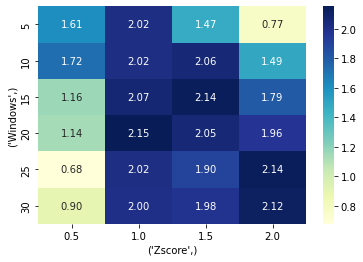

In [1529]:
Sensitivity(test)

In [1530]:
# 不同参数的PNL曲线

pair_trading(df=arbitrage, zscore=1, window=10, maxdown=-0.01)
test1 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】触及止损点平仓于 2015-07-20
【建仓】做空价差于 2015-08-03 买入 331.0 手玉米 126.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】卖出平仓于 2015-09-08
【建仓】做多价差于 2015-10-13 买入 273.0 手鸡蛋
【平仓】触及止损点平仓于 2015-10-14
【建仓】做多价差于 2015-10-20 买入 275.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】触及止损点平仓于 2015-11-11
【建仓】做空价差于 2015-11-16 买入 359.0 手玉米 138.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-04 买入 306.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做多价差于 2016-02-19 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-01 买入 416.

In [1531]:
pair_trading(df=arbitrage, zscore=1, window=30, maxdown=-0.01)
test2 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-24 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-04-28
【建仓】做空价差于 2015-04-30 买入 267.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2015-05-05
【建仓】做空价差于 2015-05-06 买入 267.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-05-14
【建仓】做空价差于 2015-05-15 买入 266.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2015-05-27
【建仓】做空价差于 2015-05-28 买入 271.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】触及止损点平仓于 2015-07-06
【建仓】做空价差于 2015-07-07 买入 320.0 手玉米 124.0 手豆粕
【平仓】买入平仓于 2015-07-08
【建仓】做空价差于 2015-08-05 买入 331.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-10-15 买入 272.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-22 买入 305.0 手鸡蛋
【平仓】触及止损点平仓于 2016-01-13
【建仓】做多价差于 2016-01-18 买入 309.0 手鸡蛋
【平仓】触及止损点平仓于 

In [1532]:
pair_trading(df=arbitrage, zscore=2, window=10, maxdown=-0.01)
test3 = arbitrage[['Portfolio Returns']]

【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-18 买入 249.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-25 买入 449.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2016-05-06
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】触及止损点平仓于 2016-08-23
【建仓】做空价差于 2017-04-13 买入 408.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-17
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-20
【建仓】做空价差于 2017-04-21 买入 405.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-25
【建仓】做空价差于 2017-04-2

In [1533]:
pair_trading(df=arbitrage, zscore=2, window=30, maxdown=-0.01)
test4 = arbitrage[['Portfolio Returns']]

【建仓】做空价差于 2015-03-30 买入 264.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-07-22 买入 321.0 手玉米 122.0 手豆粕
【平仓】触及止损点平仓于 2015-07-23
【建仓】做空价差于 2015-07-30 买入 334.0 手玉米 125.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-12-02 买入 301.0 手鸡蛋
【平仓】触及止损点平仓于 2015-12-08
【建仓】做空价差于 2016-03-30 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】触及止损点平仓于 2016-04-08
【建仓】做空价差于 2016-04-11 买入 465.0 手玉米 142.0 手豆粕
【平仓】触及止损点平仓于 2016-04-13
【建仓】做空价差于 2016-04-14 买入 450.0 手玉米 136.0 手豆粕
【平仓】触及止损点平仓于 2016-04-18
【建仓】做空价差于 2016-04-19 买入 448.0 手玉米 133.0 手豆粕
【平仓】触及止损点平仓于 2016-04-20
【建仓】做空价差于 2016-04-21 买入 423.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-04-29
【建仓】做空价差于 2016-05-03 买入 432.0 手玉米 123.0 手豆粕
【平仓】触及止损点平仓于 2016-05-04
【建仓】做空价差于 2016-05-05 买入 438.0 手玉米 125.0 手豆粕
【平仓】触及止损点平仓于 2016-05-10
【建仓】做空价差于 2016-05-11 买入 428.0 手玉米 121.0 手豆粕
【平仓】买入平仓于 2016-05-13
【建仓】做空价差于 2017-04-18 买入 410.0 手玉米 119.0 手豆粕
【平仓】触及止损点平仓于 2017-04-20
【建仓】做空价差于 2017-04-21 买入 405.0 手玉米 118.0 手豆粕
【平仓】触及止损点平仓于 2017-04-25

In [1534]:
pair_trading(df=arbitrage, zscore=1, window=10, maxdown=-0.05)
test5 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-18
【建仓】做空价差于 2015-04-01 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-04 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-06-09
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-02
【建仓】做空价差于 2015-07-16 买入 319.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-08-05
【建仓】做多价差于 2015-08-31 买入 256.0 手鸡蛋
【平仓】卖出平仓于 2015-09-08
【建仓】做多价差于 2015-10-13 买入 273.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-09 买入 353.0 手玉米 135.0 手豆粕
【平仓】买入平仓于 2015-11-17
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-04 买入 306.0 手鸡蛋
【平仓】卖出平仓于 2016-01-21
【建仓】做多价差于 2016-02-19 买入 324.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-03-01 买入 416.0 手玉米 145.0 手豆粕
【平仓】触及止损点平仓于 2016-03-24
【建仓】做空价差于 2016-03-31 买入 467.0 手玉米 144.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】买入平仓于 2016-05-03
【建仓】做多价差于 2016-05-17 买入 

In [1535]:
pair_trading(df=arbitrage, zscore=1, window=30, maxdown=-0.05)
test6 = arbitrage[['Portfolio Returns']]

【建仓】做多价差于 2015-02-25 买入 239.0 手鸡蛋
【平仓】卖出平仓于 2015-02-27
【建仓】做空价差于 2015-03-04 买入 262.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2015-03-06
【建仓】做多价差于 2015-03-16 买入 241.0 手鸡蛋
【平仓】卖出平仓于 2015-03-24
【建仓】做空价差于 2015-04-02 买入 265.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-07
【建仓】做空价差于 2015-04-24 买入 267.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2015-06-03
【建仓】做空价差于 2015-06-30 买入 315.0 手玉米 131.0 手豆粕
【平仓】买入平仓于 2015-07-08
【建仓】做空价差于 2015-08-05 买入 331.0 手玉米 123.0 手豆粕
【平仓】买入平仓于 2015-08-12
【建仓】做多价差于 2015-10-15 买入 272.0 手鸡蛋
【平仓】卖出平仓于 2015-11-03
【建仓】做空价差于 2015-11-25 买入 357.0 手玉米 144.0 手豆粕
【平仓】买入平仓于 2015-11-26
【建仓】做多价差于 2015-12-22 买入 305.0 手鸡蛋
【平仓】卖出平仓于 2016-02-22
【建仓】做空价差于 2016-04-26 买入 433.0 手玉米 128.0 手豆粕
【平仓】买入平仓于 2016-05-13
【建仓】做空价差于 2016-07-08 买入 438.0 手玉米 109.0 手豆粕
【平仓】买入平仓于 2016-07-27
【建仓】做多价差于 2016-08-17 买入 283.0 手鸡蛋
【平仓】卖出平仓于 2016-10-13
【建仓】做空价差于 2016-11-16 买入 428.0 手玉米 119.0 手豆粕
【平仓】买入平仓于 2016-11-24
【建仓】做多价差于 2016-12-22 买入 296.0 手鸡蛋
【平仓】卖出平仓于 2017-01-11
【建仓】做多价差于 2017-01-25 买入 295.0 手鸡蛋
【平仓】卖出平仓于 2017-04-12
【建仓】做空价差于 2017-05-03 买入 408.0 

In [1536]:
pair_trading(df=arbitrage, zscore=2, window=10, maxdown=-0.05)
test7 = arbitrage[['Portfolio Returns']]

【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-18 买入 249.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】卖出平仓于 2016-01-21
【建仓】做空价差于 2016-03-25 买入 449.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】买入平仓于 2016-05-03
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】卖出平仓于 2016-09-08
【建仓】做空价差于 2017-04-13 买入 408.0 手玉米 118.0 手豆粕
【平仓】买入平仓于 2017-05-08
【建仓】做空价差于 2017-08-07 买入 399.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2017-08-21
【建仓】做空价差于 2017-08-22 买入 384.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2017-08-25
【建仓】做多价差于 2017-12-05 买入 255.0 手鸡蛋
【平仓】卖出平仓于 2018-02-12
【建仓】做多价差于 2018-03-06 买入 271.0 手鸡蛋
【平仓】卖出平仓于 2018-03-15
【建仓】做空价差于 2018-04-10 买入 382.0 手玉米 103.0 手豆粕
【平仓】买入平仓于 2018-06-27
【建仓】做多价差于 2018-08-07 买入 266.0 手鸡蛋
【平仓】卖出平仓于 2018-08-28
【建仓】做空价差于 2018-10-16 买入 360.0 手玉米 98.0 手豆粕
【平仓】买入平仓于 2018-11-21
【建仓】做多价差于 2018-12-10 买入 289.0 手鸡蛋
【平仓】卖出平仓于 2019-01-11
【建仓】做空价差于 2019-04-09 买入 358.0 手玉米 128.0 手豆粕
【平仓】买入平仓于 2019-05-17
【建仓】做多价差于 2019-08-06 买入 2

In [1537]:
pair_trading(df=arbitrage, zscore=2, window=10, maxdown=-0.05)
test8 = arbitrage[['Portfolio Returns']]

【建仓】做空价差于 2015-03-25 买入 263.0 手玉米 120.0 手豆粕
【平仓】买入平仓于 2015-04-03
【建仓】做多价差于 2015-06-18 买入 249.0 手鸡蛋
【平仓】卖出平仓于 2015-06-24
【建仓】做多价差于 2015-11-30 买入 304.0 手鸡蛋
【平仓】卖出平仓于 2016-01-21
【建仓】做空价差于 2016-03-25 买入 449.0 手玉米 139.0 手豆粕
【平仓】触及止损点平仓于 2016-04-05
【建仓】做空价差于 2016-04-06 买入 466.0 手玉米 143.0 手豆粕
【平仓】买入平仓于 2016-05-03
【建仓】做多价差于 2016-08-02 买入 291.0 手鸡蛋
【平仓】卖出平仓于 2016-09-08
【建仓】做空价差于 2017-04-13 买入 408.0 手玉米 118.0 手豆粕
【平仓】买入平仓于 2017-05-08
【建仓】做空价差于 2017-08-07 买入 399.0 手玉米 121.0 手豆粕
【平仓】触及止损点平仓于 2017-08-21
【建仓】做空价差于 2017-08-22 买入 384.0 手玉米 122.0 手豆粕
【平仓】买入平仓于 2017-08-25
【建仓】做多价差于 2017-12-05 买入 255.0 手鸡蛋
【平仓】卖出平仓于 2018-02-12
【建仓】做多价差于 2018-03-06 买入 271.0 手鸡蛋
【平仓】卖出平仓于 2018-03-15
【建仓】做空价差于 2018-04-10 买入 382.0 手玉米 103.0 手豆粕
【平仓】买入平仓于 2018-06-27
【建仓】做多价差于 2018-08-07 买入 266.0 手鸡蛋
【平仓】卖出平仓于 2018-08-28
【建仓】做空价差于 2018-10-16 买入 360.0 手玉米 98.0 手豆粕
【平仓】买入平仓于 2018-11-21
【建仓】做多价差于 2018-12-10 买入 289.0 手鸡蛋
【平仓】卖出平仓于 2019-01-11
【建仓】做空价差于 2019-04-09 买入 358.0 手玉米 128.0 手豆粕
【平仓】买入平仓于 2019-05-17
【建仓】做多价差于 2019-08-06 买入 2

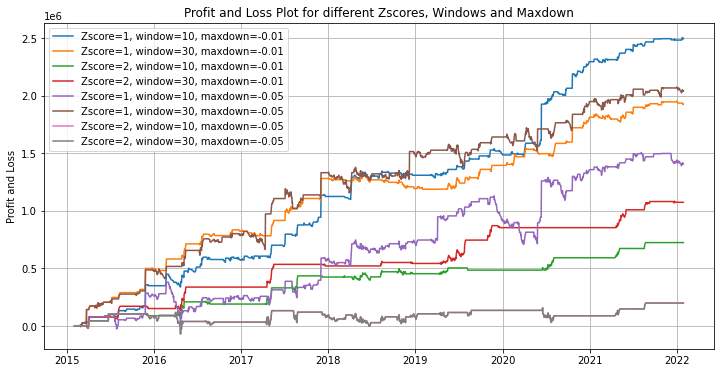

In [1541]:
# 绘制不同参数PNL曲线图
plt.figure(figsize=(12,6))
plt.plot((test1['Portfolio Returns']).cumsum(),label='Zscore=1, window=10, maxdown=-0.01')    
plt.plot((test2['Portfolio Returns']).cumsum(),label='Zscore=1, window=30, maxdown=-0.01')    
plt.plot((test3['Portfolio Returns']).cumsum(),label='Zscore=2, window=10, maxdown=-0.01')    
plt.plot((test4['Portfolio Returns']).cumsum(),label='Zscore=2, window=30, maxdown=-0.01')    
plt.plot((test5['Portfolio Returns']).cumsum(),label='Zscore=1, window=10, maxdown=-0.05')    
plt.plot((test6['Portfolio Returns']).cumsum(),label='Zscore=1, window=30, maxdown=-0.05')    
plt.plot((test7['Portfolio Returns']).cumsum(),label='Zscore=2, window=10, maxdown=-0.05')    
plt.plot((test8['Portfolio Returns']).cumsum(),label='Zscore=2, window=30, maxdown=-0.05') 
plt.ylabel('Profit and Loss')
plt.title('Profit and Loss Plot for different Zscores, Windows and Maxdown')
plt.legend()
plt.grid()
plt.show()